# Load the model


In [1]:
from transformers import AutoModelForCausalLM, AutoProcessor
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    print("CUDA Device Name:", torch.cuda.get_device_name(device.index))
else:
    print("No CUDA device available.")

CUDA Device Name: NVIDIA GeForce GTX 1660 Ti


In [3]:
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Florence-2-base-ft",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
    revision='refs/pr/6'
).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft",
    trust_remote_code=True, revision='refs/pr/6')

for param in model.vision_tower.parameters():
  param.is_trainable = False

/home/umair/anaconda3/envs/florence-recaptcha/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Create the Dataset


In [4]:
# !unzip "/content/drive/MyDrive/GitHub Projects/Google_Recaptcha_V2_Images_Dataset.zip" -d /content/dataset

In [5]:
import pandas as pd
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

plt.style.use('ggplot')

In [6]:
DATASET_ROOT_DIR = "Google_Recaptcha_V2_Images_Dataset"

In [7]:
def create_csv(dataset_dir, save_path):
    classes = os.listdir(os.path.join(dataset_dir, 'images'))

    dataset = {'filepath': [], 'label': []}

    for c in tqdm(classes):
        if c == "Other":
            continue

        filepaths = [os.path.join('images', c, path) for path in os.listdir(os.path.join(dataset_dir, 'images', c))]

        dataset['filepath'].extend(filepaths)
        dataset['label'].extend([c] * len(filepaths))

    df = pd.DataFrame(dataset)
    df.to_csv(save_path, index=False)

    return df

# df = create_csv(DATASET_ROOT_DIR, 'dataset.csv')

df = pd.read_csv('dataset.csv')

### To remove later when fully training


In [8]:
car_df = df[df['label'] == "Car"]
sampled_car_df = car_df.sample(frac=0.7, random_state=42)
df = df[~df.index.isin(sampled_car_df.index)]

## Class distribution


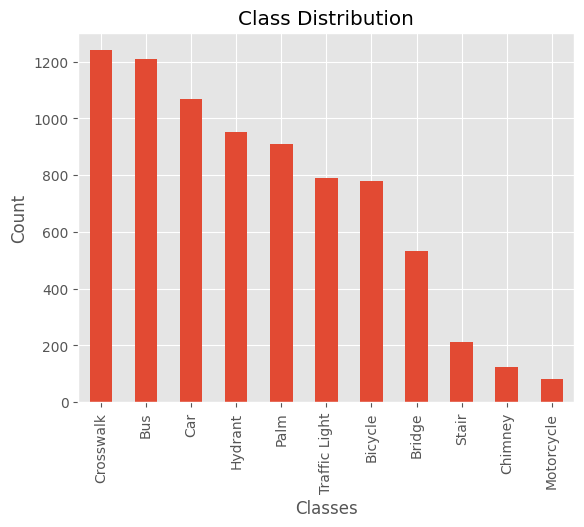

In [9]:
df['label'].value_counts().plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

## Train, Test, Val Splits


In [10]:
from sklearn.model_selection import train_test_split

def split_dataframe(df, test_fraction=0.2, val_fraction=0.1):
    train_df, temp_df = train_test_split(df, test_size=test_fraction + val_fraction, random_state=42)
    val_relative_fraction = val_fraction / (test_fraction + val_fraction)
    test_df, val_df = train_test_split(temp_df, test_size=val_relative_fraction, random_state=42)

    return train_df, test_df, val_df

train_df, test_df, val_df = split_dataframe(df, test_fraction=0.4, val_fraction=0.2)

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print(f"Val size: {len(val_df)}")

Train size: 3159
Test size: 3160
Val size: 1580


## Pytorch Dataset and Collate Function


In [11]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class CaptchDataset(Dataset):
    def __init__(self, data, root_dir):
        self.data = data
        self.root_dir = root_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data.iloc[idx]

        tag = "<recaptcha>"
        label = example['label']

        filepath = os.path.join(self.root_dir, example['filepath'])
        image = Image.open(filepath)
        image = image.convert("RGB")

        return tag, label, image

In [12]:
from torch.utils.data import DataLoader
from transformers import get_scheduler
from torch.optim import AdamW

def collate_fn(batch):
    tags, labels, images = zip(*batch)
    inputs = processor(text=list(tags), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, labels

train_dataset = CaptchDataset(train_df, DATASET_ROOT_DIR)
val_dataset = CaptchDataset(val_df, DATASET_ROOT_DIR)
batch_size = 2
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                          collate_fn=collate_fn, num_workers=num_workers)

# Training


In [13]:
import json

In [14]:
def train_one_epoch(epoch, n_epochs, optimizer, lr_scheduler):
    model.train()
    train_loss = 0
    i = -1
    for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch}/{n_epochs}"):
        i += 1
        input_ids = inputs["input_ids"]
        pixel_values = inputs["pixel_values"].to(torch.bfloat16)
        labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    print(f"Average Training Loss: {avg_train_loss}\n")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch}/{n_epochs}"):
            inputs, answers = batch
            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"].to(torch.bfloat16)
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)
            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Average Validation Loss: {avg_val_loss}\n")

    return avg_train_loss, avg_val_loss

In [15]:
def create_exp_dir(output_dir):
    os.makedirs(output_dir, exist_ok=True)

    exp_dirs = [d for d in os.listdir(output_dir) if d.startswith("exp_")]
    if exp_dirs:
        latest_exp_num = max(int(d.split("_")[1]) for d in exp_dirs)
    else:
        latest_exp_num = 0

    new_exp_num = latest_exp_num + 1
    exp_dir = os.path.join(output_dir, f"exp_{new_exp_num}")
    os.makedirs(exp_dir, exist_ok=True)

    return exp_dir

In [16]:
def save_plot(n_epochs, history, exp_dir):
    plt.figure()
    plt.plot(range(1, n_epochs + 1), history['train_loss'], label='Training Loss')
    plt.plot(range(1, n_epochs + 1), history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(exp_dir, 'plot.png'))
    plt.close()

In [17]:
def train_and_save(n_epochs, optimizer, lr_scheduler, output_dir='results'):
    exp_dir = create_exp_dir(output_dir)

    best_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(1, n_epochs + 1):
        avg_train_loss, avg_val_loss = train_one_epoch(epoch, n_epochs, optimizer, lr_scheduler)
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), os.path.join(exp_dir, 'weights', f'best_model.pth'))

        with open(os.path.join(exp_dir, 'history.json'), 'w') as f:
            json.dump(history, f, indent=2)
    
    torch.save(model.state_dict(), os.path.join(exp_dir, 'weights', f"final_epoch_{n_epochs}.pth"))

    save_plot(n_epochs, history, exp_dir)

In [18]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=1e-6)
num_training_steps = EPOCHS * len(train_loader)

lr_scheduler = get_scheduler(name="linear", optimizer=optimizer,
                              num_warmup_steps=0, num_training_steps=num_training_steps)

In [19]:
train_and_save(EPOCHS, optimizer, lr_scheduler)

Training Epoch 1/5: 100%|██████████| 1580/1580 [42:29<00:00,  1.61s/it]


Average Training Loss: 4.715407436708861



Validation Epoch 1/5: 100%|██████████| 790/790 [07:03<00:00,  1.87it/s]


Average Validation Loss: 4.3208465189873415



Training Epoch 2/5: 100%|██████████| 1580/1580 [40:46<00:00,  1.55s/it]


Average Training Loss: 4.451211431962025



Validation Epoch 2/5: 100%|██████████| 790/790 [06:50<00:00,  1.92it/s]


Average Validation Loss: 4.26339003164557



Training Epoch 3/5: 100%|██████████| 1580/1580 [42:11<00:00,  1.60s/it]


Average Training Loss: 4.450736748417722



Validation Epoch 3/5: 100%|██████████| 790/790 [07:06<00:00,  1.85it/s]


Average Validation Loss: 4.259305775316456



Training Epoch 4/5: 100%|██████████| 1580/1580 [40:46<00:00,  1.55s/it]


Average Training Loss: 4.394585640822785



Validation Epoch 4/5: 100%|██████████| 790/790 [06:53<00:00,  1.91it/s]


Average Validation Loss: 4.259246439873418



Training Epoch 5/5: 100%|██████████| 1580/1580 [42:38<00:00,  1.62s/it]


Average Training Loss: 4.406348892405063



Validation Epoch 5/5: 100%|██████████| 790/790 [07:00<00:00,  1.88it/s]


Average Validation Loss: 4.259325553797468

